In [231]:
import warnings
import copy

import awkward as ak
import dask
import uproot
import dask_awkward as dak
import uproot
import coffea.nanoevents
from coffea.nanoevents import PHYSLITESchema, NanoEventsFactory
import matplotlib.pyplot as plt

In [3]:
%run utils.py # TODO: maybe make this a class

In [244]:
%run patched_physlite_schema.py

In [245]:
coffea.nanoevents.factory.PHYSLITESchema = PHYSLITESchema

In [120]:
#%run aiohttpsource.py

In [167]:
%run fsspec_source.py

In [124]:
rse = "GOOGLE-EU_DATADISK"

In [6]:
from ipywidgets import FileUpload
upload = FileUpload()
display(upload)

FileUpload(value=(), description='Upload')

In [7]:
x509_data = bytes(upload.value[0]["content"])
setup_rucio_and_proxy(x509_data, rucio_account="nihartma")

In [169]:
class RucioFileGCPSource(FSSpecHttpSource):
    def __init__(self, file_path, **kwargs):
        scope, name = file_path.split(".", maxsplit=1)
        url = get_signed_url_worker(x509_data, scope, name, rse=rse,
                                    #ca_cert="cern_bundle.pem"
                                    ca_cert=False,
                                   )
        super().__init__(url, **kwargs)

In [170]:
from functools import wraps, partial

In [171]:
def patch_uproot_dask(f):
    return wraps(f)(partial(f, file_handler=RucioFileGCPSource))

In [172]:
if hasattr(uproot.dask, "__wrapped__"):
    # unpatch if already patched
    uproot.dask = uproot.dask.__wrapped__

if not hasattr(uproot.dask, "__wrapped__"):
    # patch if not patched
    uproot.dask = patch_uproot_dask(uproot.dask)

In [173]:
filename = "mc21_13p6TeV.DAOD_PHYSLITE.33080408._000001.pool.root.1" # in scope.filename format

In [174]:
factory = NanoEventsFactory.from_root(
    {filename: "CollectionTree"},
    schemaclass=PHYSLITESchema,
    permit_dask=True
)

In [175]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    events = factory.events()

In [176]:
events

dask.awkward<from-uproot, npartitions=1>

In [177]:
#events.Electrons.caloClusters.fields # need to wire this up correctly (diffirent name)

In [178]:
events.Electrons.fields

['pt',
 '_eventindex',
 'eta',
 'phi',
 'm',
 'charge',
 'topoetcone20',
 'truthType',
 'truthOrigin',
 'neflowisol20',
 'DFCommonElectronsLHLoose',
 'author',
 'OQ',
 'ambiguityType',
 'ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
 'ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt500',
 'ptcone20_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
 'ptvarcone30_Nonprompt_All_MaxWeightTTVALooseCone_pt1000',
 'DFCommonElectronsLHVeryLoose',
 'DFCommonElectronsLHVeryLooseIsEMValue',
 'DFCommonElectronsLHLooseIsEMValue',
 'DFCommonElectronsLHLooseBL',
 'DFCommonElectronsLHLooseBLIsEMValue',
 'DFCommonElectronsLHMedium',
 'DFCommonElectronsLHMediumIsEMValue',
 'DFCommonElectronsLHTight',
 'DFCommonElectronsLHTightIsEMValue',
 'DFCommonElectronsECIDS',
 'DFCommonElectronsECIDSResult',
 'truthPdgId',
 'firstEgMotherTruthType',
 'firstEgMotherTruthOrigin',
 'firstEgMotherPdgId',
 'trackParticleLinks',
 'ambiguityLink',
 'truthParticleLink',
 'TruthLink',
 'caloClusterLinks',
 'firstEgMo

In [182]:
events.Electrons.px.compute()

<Array [[-5.12e+03], [], [1.35e+05], ..., [], []] type='20000 * var * float32'>

In [183]:
dak.necessary_columns(events.Electrons.px)

{'from-uproot-ff36d0c245add408a981ed63f1b504bc': ['Electrons.phi',
  'Electrons.pt']}

In [184]:
events.Electrons.trackParticles.pt.compute()

<Array [[[4.59e+03]], [], [[...]], ..., [], []] type='20000 * var * var * ?...'>

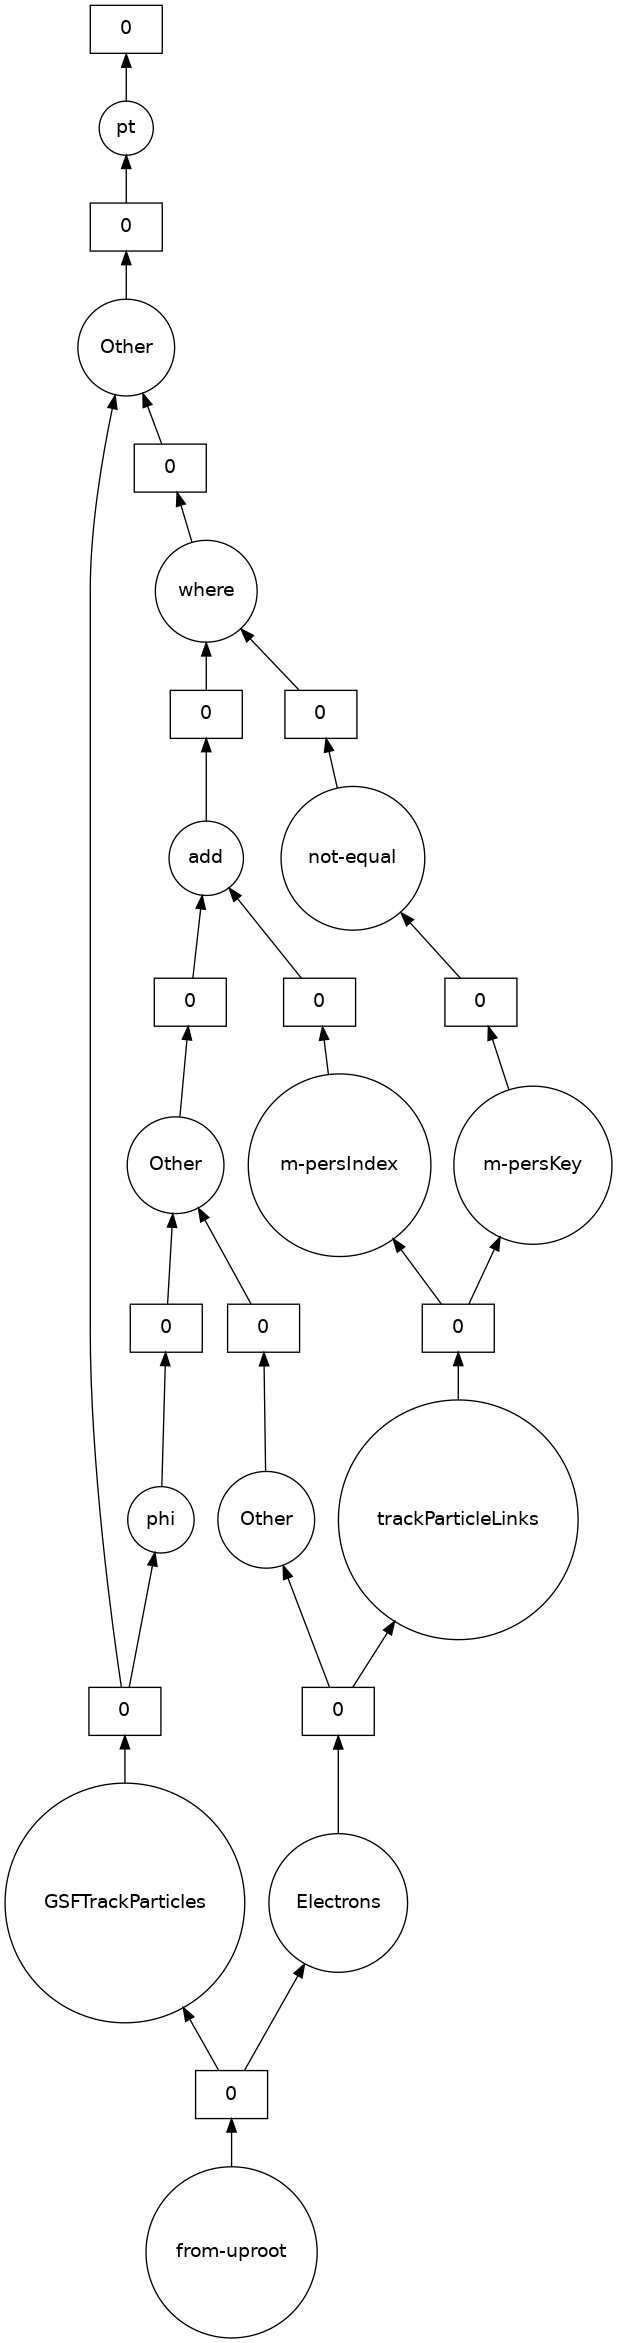

In [141]:
events.Electrons.trackParticles.pt.visualize()

In [25]:
dak.necessary_columns(events.Electrons.trackParticles.pt)

{'from-uproot-c38a8a44bf786d948dff4b94dfd3b1d4': ['GSFTrackParticles.theta',
  'Electrons.trackParticleLinks.m_persIndex',
  'GSFTrackParticles.qOverP',
  'Electrons.trackParticleLinks.m_persKey',
  'Electrons._eventindex',
  'GSFTrackParticles.phi']}

In [26]:
GeV = 1000.

In [142]:
# TODO: replace by more realistic selections
def electron_selection(el):
    return (el.pt > 30 * GeV) & (abs(el.eta) < 2.47)

def muon_selection(mu):
    return (mu.pt > 30 * GeV) & (abs(mu.eta) < 2.47)

def jet_selection(j):
    return (j.pt > 30 * GeV) & (abs(j.eta) < 2.47)

In [143]:
def selection(events):
    #events = copy.copy(events) # make shallow copy - needs https://github.com/dask-contrib/dask-awkward/pull/324
    events = ak.with_field(events, events.Jets, "Jets") # workaround

    # TODO: overlap removal

    # decorations
    events["Jets", "btagging"] = events.BTagging_AntiKt4EMPFlow # technically this is an ElementLink, but seems in PHYSLITE exactcly one link for each jet
    events["Jets", "is_bjet"] = events.Jets.btagging.DL1dv01_pb > 0.85 # is this how to select 85% working point?

    # object selection
    events["Electrons"] = events.Electrons[electron_selection(events.Electrons)]
    events["Muons"] = events.Muons[muon_selection(events.Muons)]
    events["Jets"] = events.Jets[jet_selection(events.Jets)]

    # event selection
    events = events[
        (ak.num(events.Jets) >= 4) # at least 4 jets
        & ((ak.num(events.Electrons) + ak.num(events.Muons)) == 1) # exactly 1 Lepton
        & (ak.sum(events.Jets.is_bjet, axis=1) >= 2) # at least 2 bjets
    ]
    return events

In [144]:
events.Electrons.pt

dask.awkward<pt, npartitions=1>

In [185]:
ev_sel = selection(events)

Note: Now we need all columns used in the selection to calculate everything:

In [186]:
dak.necessary_columns(ev_sel.Jets.is_bjet)

{'from-uproot-ff36d0c245add408a981ed63f1b504bc': ['Jets.pt',
  'Jets.eta',
  'BTagging_AntiKt4EMPFlow.DL1dv01_pb',
  'Muons.eta',
  'Muons.pt',
  'Electrons.eta',
  'Electrons.pt']}

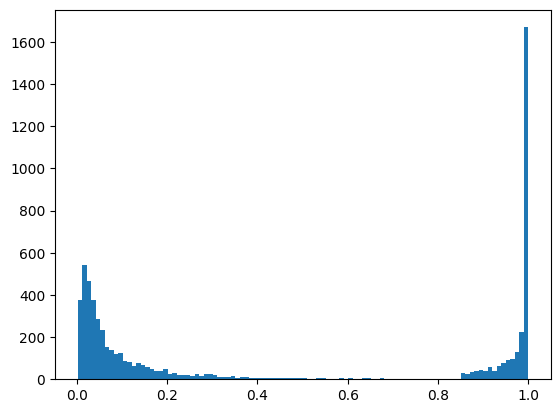

In [187]:
plt.hist(ak.flatten(ev_sel.Jets.btagging.DL1dv01_pb.compute()).to_numpy(), bins=100);

Now, reconstruct top quark from 3 jets

In [188]:
def mjjj(jets):
    candidates = ak.combinations(jets, 3)
    j1, j2, j3 = ak.unzip(candidates)
    has_b = (j1.is_bjet + j2.is_bjet + j3.is_bjet) > 0
    candidates["p4"] = j1 + j2 + j3
    candidates = candidates[has_b]
    candidates = candidates[ak.argmax(candidates.p4.pt, axis=1, keepdims=True)]
    return ak.flatten(candidates.p4.mass, axis=None)

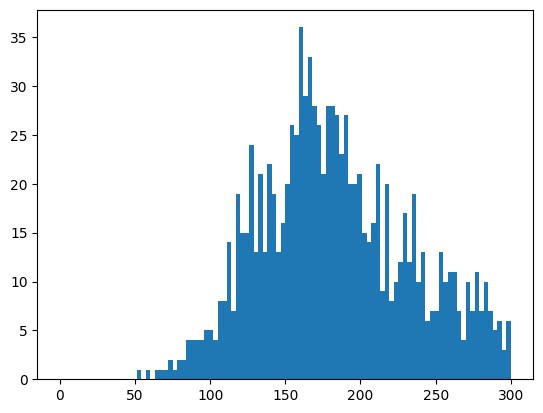

In [189]:
plt.hist(mjjj(ev_sel.Jets).compute().to_numpy() / GeV, bins=100, range=(0, 300));

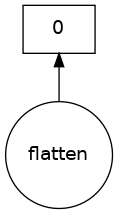

In [190]:
mjjj(ev_sel.Jets).visualize(optimize_graph=True)

Now, go distributed

In [191]:
from dask_gateway import Gateway
gateway = Gateway()

In [192]:
clusters = gateway.list_clusters()
clusters

[ClusterReport<name=default.9a4ff95044024f338c1928cc780ff6ea, status=RUNNING>]

In [193]:
cluster = gateway.connect(clusters[0].name)

In [194]:
client = cluster.get_client()

In [195]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/default.9a4ff95044024f338c1928cc780ff6ea/status,


In [196]:
obs = mjjj(ev_sel.Jets)

In [197]:
obs.compute()

<Array [3.33e+05, 1.19e+05, ..., 1.92e+05, 2.46e+05] type='1316 * float32'>

In [198]:
import rucio.client
rucio_client = rucio.client.Client(ca_cert="cern_bundle.pem")

In [199]:
files = list(
    rucio_client.list_files(
        "mc21_13p6TeV", "mc21_13p6TeV.601229.PhPy8EG_A14_ttbar_hdamp258p75_SingleLep.deriv.DAOD_PHYSLITE.e8453_s3873_r13829_p5631"
    )
)

In [200]:
files[0]

{'scope': 'mc21_13p6TeV',
 'name': 'DAOD_PHYSLITE.33080408._000001.pool.root.1',
 'bytes': 332389289,
 'adler32': '1165dc9c',
 'guid': 'FED4AB7C699ABB479E236074128FA917',
 'events': 20000}

In [201]:
len(files)

538

In [246]:
def get_events(files):
    factory = NanoEventsFactory.from_root(
        {f"{file['scope']}.{file['name']}": "CollectionTree" for file in files},
        schemaclass=PHYSLITESchema,
        permit_dask=True,
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        events = factory.events()
    
    return events

In [247]:
#events = get_events(files[:160])
events = get_events(files)

In [248]:
events

dask.awkward<from-uproot, npartitions=538>

In [249]:
darray_ttbar = mjjj(selection(events).Jets)

In [250]:
darray_ttbar

dask.awkward<flatten, npartitions=538>

In [207]:
array_ttbar = darray_ttbar.compute()

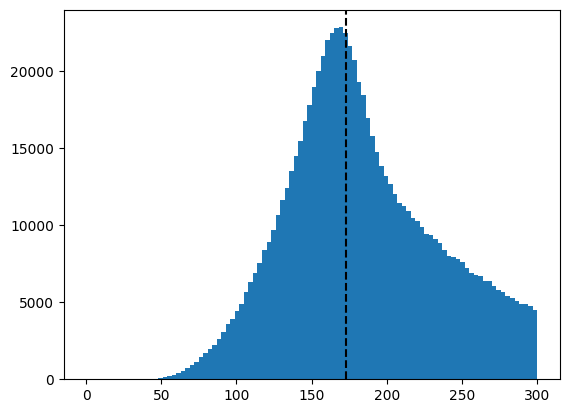

In [238]:
plt.hist(array_ttbar.to_numpy() / GeV, bins=100, range=(0, 300));
plt.axvline(172.76, linestyle="--", color="black")

In [209]:
files_wenu = list(
    rucio_client.list_files(
    "mc21_13p6TeV",
    "mc21_13p6TeV.513093.MGPy8EG_Wenu_FxFx3jHT2bias_SW_BFilter.deriv.DAOD_PHYSLITE.e8453_s3873_s3874_r13829_r13831_p5631_tid33080269_00",
    )
)

In [210]:
len(files_wenu)

45

In [226]:
events_wenu = get_events(files_wenu[:160])

In [227]:
events_wenu

dask.awkward<from-uproot, npartitions=45>

In [228]:
darray_wenu = mjjj(selection(events_wenu).Jets)

In [229]:
darray_wenu

dask.awkward<flatten, npartitions=45>

In [252]:
array_ttbar, array_wenu = dask.compute(darray_ttbar, darray_wenu)

Text(0.5, 1.0, '1 Lepton, $\\geq 4$ jets, $\\geq 2$ b-tags, $\\geq 1$ b-tag per candidate')

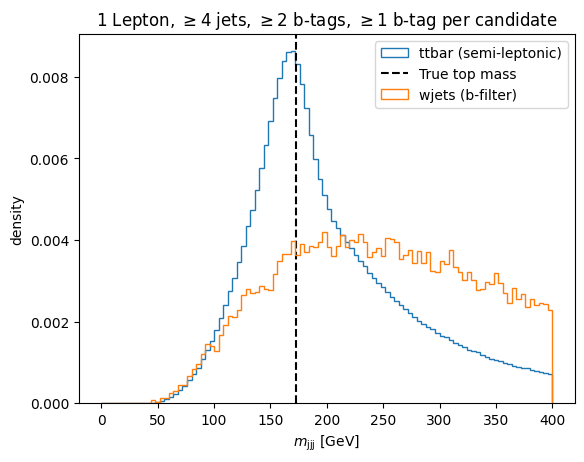

In [253]:
plt.hist(array_ttbar.to_numpy() / GeV, bins=100, range=(0, 400), histtype="step", label="ttbar (semi-leptonic)", density=True);
plt.axvline(172.76, linestyle="--", color="black", label="True top mass")
plt.hist(array_wenu.to_numpy() / GeV, bins=100, range=(0, 400), histtype="step", label="wjets (b-filter)", density=True);
plt.legend()
plt.xlabel(r"$m_\mathrm{jjj}$ [GeV]")
plt.ylabel("density")
plt.title("1 Lepton, $\geq 4$ jets, $\geq 2$ b-tags, $\geq 1$ b-tag per candidate")

In [254]:
array_ttbar

<Array [3.33e+05, 1.19e+05, ..., 1.57e+05, 2.98e+05] type='3307242 * float32'>